In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.feature import VectorAssembler

from scikitplot.metrics import plot_silhouette

import matplotlib.pyplot as plt
import numpy as np
import folium
import warnings

In [2]:
spark = SparkSession.builder.appName('pratical_work').getOrCreate()
warnings.filterwarnings('ignore')

In [3]:
data = spark.read.parquet("hdfs:///user/ghra2016/cleaned_data")

In [4]:
data.printSchema()
data.show(1)

root
 |-- id_str: string (nullable = true)
 |-- text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- x: float (nullable = true)
 |-- y: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)

+------------------+--------------------+--------+---+---+----+-----+---+----+
|            id_str|                text|hashtags|  x|  y|year|month|day|hour|
+------------------+--------------------+--------+---+---+----+-----+---+----+
|721527751338024960|To morrendo de so...|      []|NaN|NaN|2016|    4| 17|   2|
+------------------+--------------------+--------+---+---+----+-----+---+----+
only showing top 1 row



In [5]:
remove_square_brackets = F.udf(lambda s: s[1:-1])

In [6]:
data = data.withColumn("hashtags", remove_square_brackets(data.hashtags))
data = data.withColumn("hashtags", F.lower(data.hashtags))
data = data.withColumn("hashtags", F.explode(F.split("hashtags", ',')))
data = data.withColumn("hashtags", F.trim(data.hashtags))

In [7]:
hashtags_frequencies = data.filter((data.hour == 2) & (data.hashtags != ''))\
                            .groupby("hashtags")\
                            .agg(F.count('*').alias("frequency"))\
                            .sort("frequency", ascending=False)\
                            .collect()

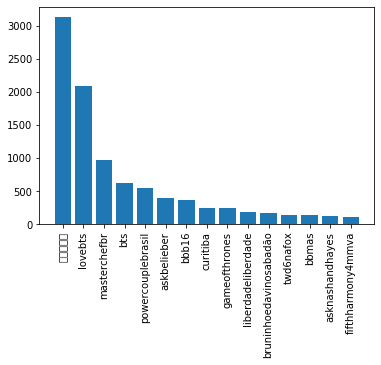

In [8]:
hashtags = [item.hashtags for item in hashtags_frequencies[:15]]
frequencies = [item.frequency for item in hashtags_frequencies[:15]]

plt.bar(hashtags, frequencies)
plt.xticks(rotation="vertical")
plt.show()

In [9]:
hashtags = hashtags[:10]
most_freq_tags = data.select("hashtags", "month", "day", "hour")\
                        .filter(data.hashtags.isin(hashtags))\
                        .groupby("hashtags", "month", "day", "hour")\
                        .agg(F.count("*").alias("freq"))\
                        .sort("hashtags", F.desc("freq"), "month", "day", "hour")\
                        .collect()

In [10]:
most_freq = []
prev_tag = ''

for item in most_freq_tags:
    if item.hashtags != prev_tag:
        most_freq.append(item)
        prev_tag = item.hashtags
        
most_freq.sort(key=lambda k: k.freq, reverse=True)

In [11]:
num_to_month = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 
                7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}

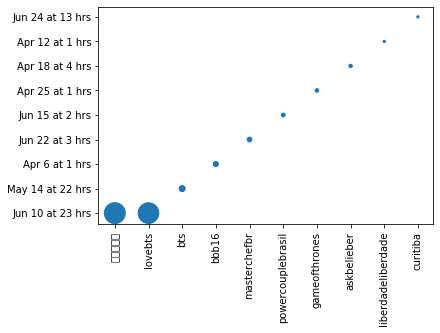

In [12]:
x = [item.hashtags for item in most_freq]
y = ["{} {} at {} hrs".format(num_to_month[item.month], item.day, item.hour) for item in most_freq]
bubble_size = [item.freq for item in most_freq]
bubble_size = np.array(bubble_size) / np.sum(bubble_size) * 1000
    
plt.scatter(x,y,s=bubble_size)
plt.xticks(rotation="vertical")
plt.title("")
plt.show()

In [13]:
w_coordinates = data.select(["hashtags", "x", "y"]).na.drop()

In [14]:
w_coordinates.show(1)

+--------+----------+--------+
|hashtags|         x|       y|
+--------+----------+--------+
|elekfans|-25.384666|-49.2776|
+--------+----------+--------+
only showing top 1 row



In [15]:
clustering_input = w_coordinates.select(["x", "y"])

In [16]:
assembler = VectorAssembler(inputCols=["x", "y"], outputCol='features')
clustering_input = assembler.transform(clustering_input)

In [17]:
SEED = 1
k_list = range(3, 30)
distances = []
sillhouettes = []
for k in k_list:
    kmeans = KMeans().setK(k).setSeed(SEED)
    model = kmeans.fit(clustering_input)
    predictions = model.transform(clustering_input)
    
    total_dist = model.computeCost(clustering_input)
    evaluator = ClusteringEvaluator()
    
    distances.append(total_dist)
    sillhouettes.append(evaluator.evaluate(predictions))

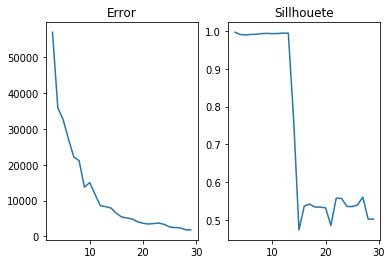

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(k_list, distances)
ax1.set_title("Error")

ax2.plot(k_list, sillhouettes)
ax2.set_title("Sillhouete")

plt.show()

In [19]:
N_CLUSTERS = 3

In [20]:
kmeans = KMeans().setK(N_CLUSTERS).setSeed(SEED)

model = kmeans.fit(clustering_input)
predictions = model.transform(clustering_input)

centroids = model.clusterCenters()

In [21]:
w_coordinates = w_coordinates.withColumn("index", F.monotonically_increasing_id())

In [22]:
predictions = predictions.select("prediction").withColumn("index", F.monotonically_increasing_id())

In [23]:
w_coordinates.show(1)
predictions.show(1)

+--------+----------+--------+-----+
|hashtags|         x|       y|index|
+--------+----------+--------+-----+
|elekfans|-25.384666|-49.2776|    0|
+--------+----------+--------+-----+
only showing top 1 row

+----------+-----+
|prediction|index|
+----------+-----+
|         0|    0|
+----------+-----+
only showing top 1 row



In [24]:
w_coordinates = w_coordinates.join(predictions, predictions.index==w_coordinates.index)
w_coordinates = w_coordinates.drop("index")

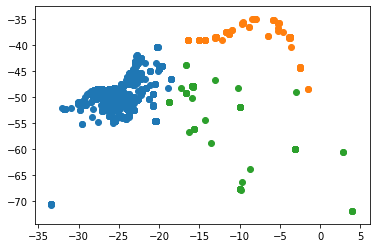

In [25]:
for k in range(N_CLUSTERS):
    k_X = w_coordinates.select(["x", "y"]).where(w_coordinates.prediction == k).toPandas().values
    plt.scatter(k_X[:, :1], k_X[:, 1:])

plt.show()

In [26]:
w_coordinates = w_coordinates.filter(w_coordinates.hashtags != '')

In [27]:
most_freq_cluster = w_coordinates.groupby("hashtags", "prediction")\
                                    .agg(F.count('*').alias("count"))\
                                    .sort("prediction", F.desc("count")).collect()

In [28]:
most_freq = []
prev_class = -1
for row in most_freq_cluster:
    if row.prediction != prev_class:
        most_freq.append(row)
        prev_class = row.prediction

In [29]:
sp = folium.Map(
    location=[-25.441105, -49.276855],
    zoom_start=4
)

hashtags = [item.hashtags for item in most_freq]
lat = [item[0] for item in centroids]
long = [item[1] for item in centroids]

for _lat, _long, tag in zip(lat, long, hashtags):
    folium.Marker(
        popup=tag,
        location=[_lat,_long]
    ).add_to(sp)

In [30]:
sp